# Graph Preprocessing
Reddit user posting behavior data can be downloaded from: https://figshare.com/articles/reddit_user_posting_behavior/874101

In [1]:
import numpy as np
from scipy import sparse
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.pyplot as plt
import csv

In [2]:
# import user-subreddit post behavior
accounts = {}
with open('data/reddit-user-posting-behavior.csv') as csvfile:
    reader = csv.reader(csvfile)
    idx = 0
    for row in reader:
        accounts[idx] = list(set(row[1:]))
        idx += 1

In [3]:
# get unique subreddits
subreddits = list(set([v for values in accounts.values() for v in values]))

# map subreddits to index mappings
subidx = {}
idx_to_sub = {}
for i in range(len(subreddits)):
    subidx[subreddits[i]] = i
    idx_to_sub[i] = subreddits[i]
    
# print total number of subreddits
print('Total subreddits: {}'.format(len(subreddits)))

Total subreddits: 15122


In [4]:
# prepare sparse cols and rows
row = []
col = []
for user,sublist in accounts.items():
    for sub in sublist:
        row.append(subidx[sub])
        col.append(user)

# build subreddit-user relation matrix
submat = sparse.csr_matrix((np.ones(len(row)),(row,col)))

# create final subreddit-subreddit realtions
srs = submat*submat.T

In [5]:
# strip small degree
pmat = srs.toarray()
pmat[pmat < 1000] = 0

# build percentage matrix
diag = 1/srs.diagonal()
pmat = np.multiply(pmat,diag.reshape((-1,1)))

# threshold percentages
pmat[pmat < 0.05] = 0

# remove edges that are only one-sided
pmat = np.multiply(pmat, pmat.T)
pmat = pmat > 0

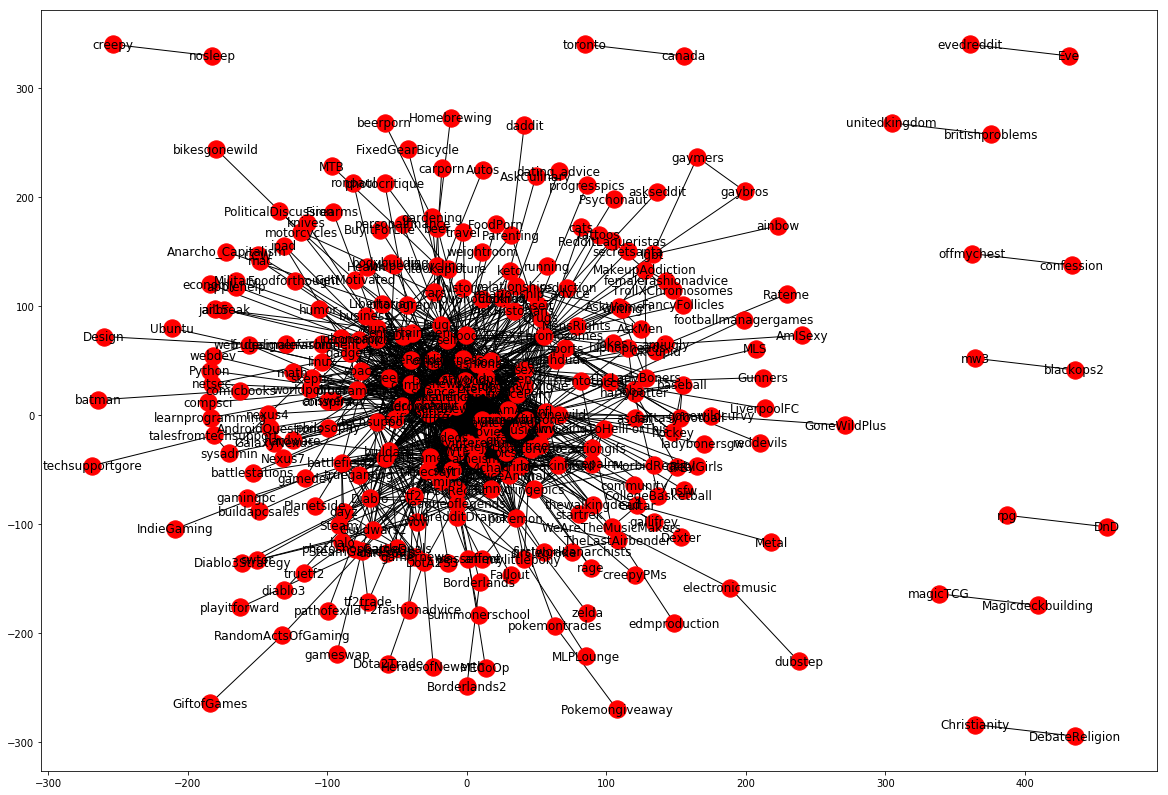

In [6]:
# create graph
G = nx.from_numpy_matrix(pmat, create_using=nx.Graph())

# relabel nodes
G = nx.relabel_nodes(G, idx_to_sub)

# remove isolates and self edges
G.remove_edges_from(list(G.selfloop_edges()))
G.remove_nodes_from(list(nx.isolates(G)))

# compute graph layout
# (only uncomment if graph has been clipped)
pos = graphviz_layout(G)

# plot the network
plt.figure(figsize=(20,14))

nx.draw_networkx(G, pos=pos)

In [7]:
# recursive modularity maximization
def modularity_max(G, k):
    # base case
    if k == 1:
        return [G]
    
    # compute graph modularity matrix
    B = nx.modularity_matrix(G)

    # find leading eigenvector of B
    evals = []
    evecs = []
    
    try:
        evals,evecs = sparse.linalg.eigs(sparse.csr_matrix(B))
    except TypeError:
        evals,evecs = np.linalg.eig(B)
    
    le = evecs[:,np.argmax(evals)]

    # split graph based on leading eigenvector
    nodes = np.array(G.nodes)
    n1 = np.where(le >= 0)[0]
    n2 = np.where(le < 0)[0]
    g1 = G.subgraph(nodes[n1])
    g2 = G.subgraph(nodes[n2])
    
    # return split graph
    if k == 2:
        return [g1,g2]
    
    # make recursive calls to continue partitioning
    if k > 2:
        m1 = modularity_max(g1,np.ceil(k/2))
        m2 = modularity_max(g2,np.floor(k/2))
        return [*m1,*m2]

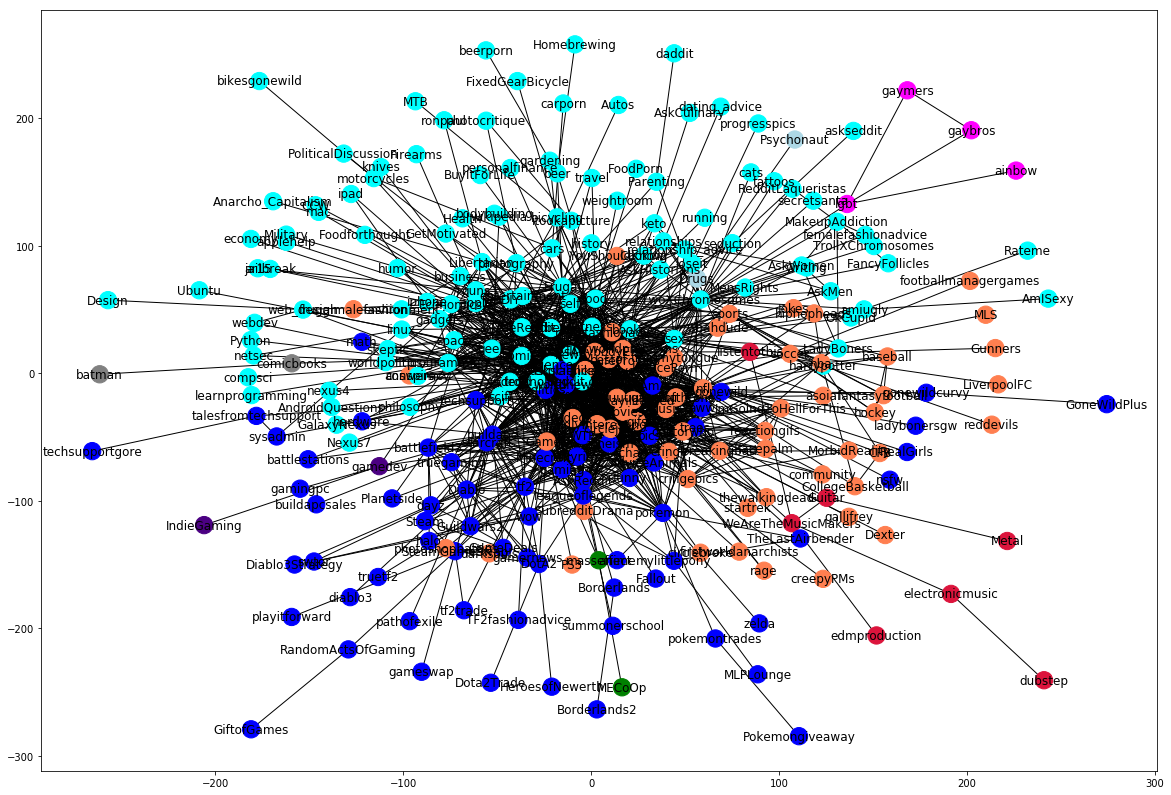

In [8]:
# find largest connected component
cc = [G.subgraph(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)][0]

# perform community detection
mm = modularity_max(cc,20)
mm = [G.subgraph(comm) for comm in greedy_modularity_communities(cc)]

# assign colors to nodes based on their community
colors = ['aqua','blue','coral','crimson','cyan','fuchsia','green','grey','indigo','lightblue','lime','magenta','orangered','pink','teal','violet','yellow','olive','maroon','khaki']
node_colors = {}
for i in range(len(mm)):
    subgraph = mm[i]
    for node in subgraph.nodes:
        node_colors[node] = colors[i]
        
d = sorted(node_colors.items(), key=lambda pair: list(cc.nodes).index(pair[0]))
d = [n[1] for n in d]

# calculate pos layout
# (only uncomment if graph has been clipped)
pos = graphviz_layout(cc)

# plot the comunities
plt.figure(figsize=(20,14))
nx.draw_networkx(cc, node_color=d, pos=pos)

In [10]:
# set color attributes
nx.set_node_attributes(cc, node_colors, 'color')

# write graph to .gexf file for Gephi
#nx.write_gexf(G,'graphs/outgraph.gexf')